In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | Pa·s                  | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | m                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [2]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista
!pip install Rtree

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [3]:
WD_PATH = "/content/drive/MyDrive/Research/3d-1d"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import importlib
from graphnics import *

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [24]:
# @title Define G = test graph, with fidelity boost
original_node_coords = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

# Define the original edges
original_edges = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]
def refine_graph(node_coords, edges, subdivisions_per_edge):
    new_G = FenicsGraph()

    # Keep track of the mapping from the original node IDs to the new graph's node IDs.
    # For the original nodes we use the same ID.
    original_to_new = {}
    for orig_node, coord in node_coords.items():
        new_G.add_node(orig_node, pos=coord)
        original_to_new[orig_node] = orig_node  # Keep the same id.

    # To create new nodes for subdivisions, start new indices from the maximum original node id + 1.
    new_node_index = max(node_coords.keys()) + 1

    # Process each original edge.
    for u, v, radius in edges:
        # Get the original coordinates for the endpoints.
        pos_u = node_coords[u]
        pos_v = node_coords[v]

        # Start with the original node u.
        current_node = original_to_new[u]

        # Insert new intermediate nodes (if subdivisions_per_edge > 0)
        for i in range(1, subdivisions_per_edge + 1):
            t = i / (subdivisions_per_edge + 1)
            new_coord = [(1 - t) * pu + t * pv for pu, pv in zip(pos_u, pos_v)]
            new_G.add_node(new_node_index, pos=new_coord)
            new_G.add_edge(current_node, new_node_index, radius=radius)
            current_node = new_node_index
            new_node_index += 1

        new_G.add_edge(current_node, original_to_new[v], radius=radius)

    return new_G

refined_G = refine_graph(original_node_coords, original_edges, 10)
original_positions = set(tuple(pos) for pos in original_node_coords.values())

print("Transformed original nodes:")
for node_id, data in refined_G.nodes(data=True):
    if tuple(data['pos']) in original_positions:
        print(f"Node ID: {node_id}, Position: {data['pos']}")

print("\nEdges of the refined graph:")
for edge_id, (u, v, data) in enumerate(refined_G.edges(data=True)):
    print(f"Edge {edge_id}: ({u}, {v}) - Radius: {data['radius']}")


Transformed original nodes:
Node ID: 0, Position: [0.0, 0.02, 0.015]
Node ID: 1, Position: [0.01, 0.02, 0.015]
Node ID: 2, Position: [0.022, 0.013, 0.015]
Node ID: 3, Position: [0.022, 0.028, 0.015]
Node ID: 4, Position: [0.015, 0.005, 0.015]
Node ID: 5, Position: [0.015, 0.035, 0.015]
Node ID: 6, Position: [0.038, 0.005, 0.015]
Node ID: 7, Position: [0.038, 0.035, 0.015]

Edges of the refined graph:
Edge 0: (0, 8) - Radius: 0.004
Edge 1: (1, 18) - Radius: 0.003
Edge 2: (1, 28) - Radius: 0.003
Edge 3: (2, 38) - Radius: 0.002
Edge 4: (2, 48) - Radius: 0.003
Edge 5: (3, 58) - Radius: 0.002
Edge 6: (3, 68) - Radius: 0.003
Edge 7: (8, 9) - Radius: 0.004
Edge 8: (9, 10) - Radius: 0.004
Edge 9: (10, 11) - Radius: 0.004
Edge 10: (11, 12) - Radius: 0.004
Edge 11: (12, 13) - Radius: 0.004
Edge 12: (13, 14) - Radius: 0.004
Edge 13: (14, 15) - Radius: 0.004
Edge 14: (15, 16) - Radius: 0.004
Edge 15: (16, 17) - Radius: 0.004
Edge 16: (17, 1) - Radius: 0.004
Edge 17: (18, 19) - Radius: 0.003
Edge 1

In [16]:
import FEMSinkVelo

In [46]:
importlib.reload(FEMSinkVelo)

<module 'FEMSinkVelo' from '/content/drive/MyDrive/Research/3d-1d/modules/FEMSinkVelo.py'>

In [51]:
fem_test = FEMSinkVelo.FEMSinkVelo(
    G=G,
    gamma = 0.1658,
    gamma_R = 1.06,
    gamma_v = 1.09,
    gamma_a = 2.245,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 3.33e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008
)

Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 951.85it/s]


Applied BC! Non-empty list


In [19]:
import Visualizer

In [52]:
importlib.reload(Visualizer)

<module 'Visualizer' from '/content/drive/MyDrive/Research/3d-1d/modules/Visualizer.py'>

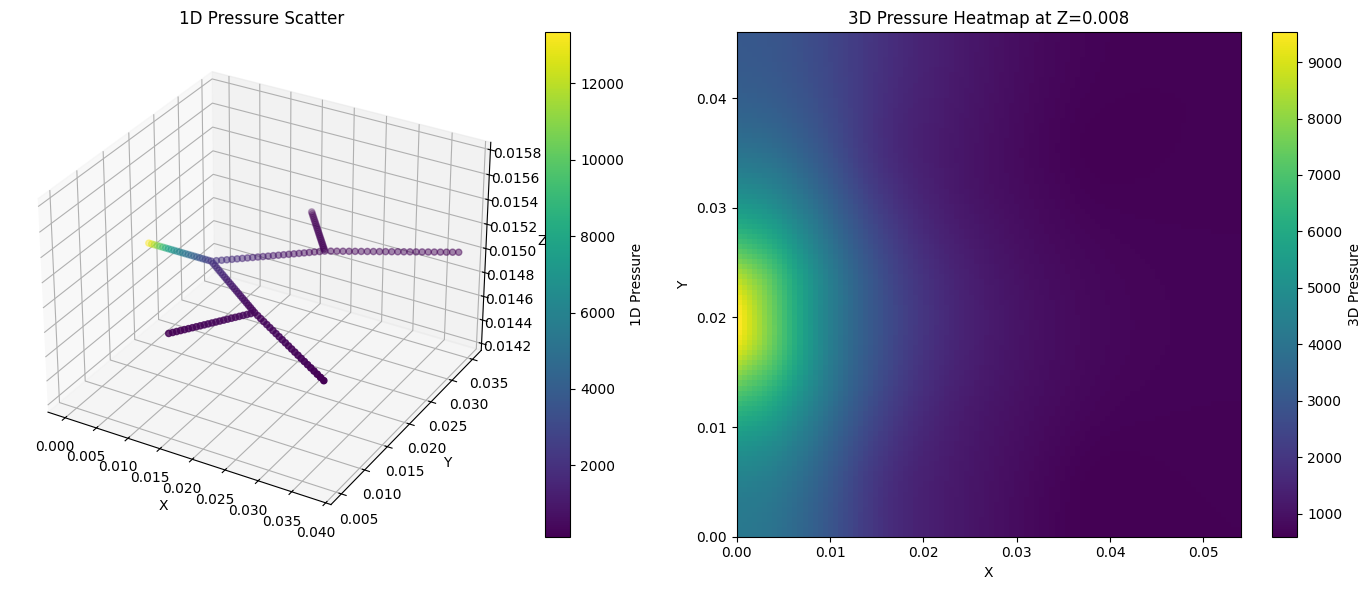

In [53]:
Visualizer.Visualizer.plot(fem_test.uh1d, fem_test.uh3d, )

In [54]:
print(fem_test.calculate_total_outflow())
print(fem_test.calculate_1d_inflow())

3.087843553468103e-06
3.087843553468103e-06


In [50]:
import numpy as np
from scipy.optimize import minimize

def black_box_flow(gamma, gamma_R, gamma_a, gamma_v, k_v=3.33e-11):
  fem_test = FEMSinkVelo.FEMSinkVelo(
      G=G,
      gamma=gamma,
      gamma_R=gamma_R,
      gamma_a=gamma_a,
      gamma_v=gamma_v,
      mu=1.0e-3,
      k_t=1.0e-10,
      k_v=k_v,
      P_in=100.0*133.322,
      p_cvp=1.0*133.322,
      Lambda_inlet=[0],
      Lambda_padding_min=0.008
  )
  flow_val = fem_test.calculate_1d_inflow()
  return flow_val

def cost_function_log(params_log, target_flow=3.333e-6, k_v=3.33e-11):
    gamma_linear    = 10.0**(params_log[0])
    gamma_R_linear  = 10.0**(params_log[1])
    gamma_a_linear  = 10.0**(params_log[2])
    gamma_v_linear  = 10.0**(params_log[3])

    # Evaluate the flow from the PDE solver
    flow_val = black_box_flow(
        gamma_linear,
        gamma_R_linear,
        gamma_a_linear,
        gamma_v_linear,
        k_v=k_v
    )

    # Least-squares difference from the target flow
    return (flow_val - target_flow)**2

def multi_param_fit(
    target_flow=500.6,
    k_v=3.33e-11,
    initial_guess_log=None,
    max_iter=50
):
    if initial_guess_log is None:
        initial_guess_log = [0.0, 0.0, 0.0, 0.0]

    result = minimize(
        fun=lambda p: cost_function_log(p, target_flow=target_flow, k_v=k_v),
        x0=np.array(initial_guess_log),
        method='Nelder-Mead',
        options={'maxiter': max_iter, 'disp': True}
    )

    best_log = result.x
    gamma_opt   = 10.0**(best_log[0])
    gammaR_opt  = 10.0**(best_log[1])
    gammaA_opt  = 10.0**(best_log[2])
    gammaV_opt  = 10.0**(best_log[3])

    flow_final = black_box_flow(gamma_opt, gammaR_opt, gammaA_opt, gammaV_opt, k_v)

    return {
        'success': result.success,
        'status': result.status,
        'message': result.message,
        'n_iters': result.nit,
        'cost_final': result.fun,
        'gamma':   gamma_opt,
        'gamma_R': gammaR_opt,
        'gamma_a': gammaA_opt,
        'gamma_v': gammaV_opt,
        'flow_final': flow_final
    }

res = multi_param_fit(target_flow=3.333e-6, k_v=3.33e-11, max_iter=30)

print("Optimization successful?", res['success'])
print("Status code:", res['status'])
print("Message:", res['message'])
print("Number of iterations:", res['n_iters'])
print("Final cost:", res['cost_final'])
print(f"gamma    = {res['gamma']:8.4g}")
print(f"gamma_R  = {res['gamma_R']:8.4g}")
print(f"gamma_a  = {res['gamma_a']:8.4g}")
print(f"gamma_v  = {res['gamma_v']:8.4g}")
print(f"flow     = {res['flow_final']:8.4g}")

Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 394.43it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 572.63it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 946.51it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 917.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 582.36it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 538.28it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 889.35it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 778.24it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 883.43it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 721.02it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 595.38it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 547.42it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 937.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 938.14it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 939.03it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 908.93it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 909.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 575.57it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 800.41it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 756.76it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 866.31it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 792.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 894.02it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 543.38it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 601.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 937.93it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 901.64it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 947.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 908.24it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 895.67it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 576.45it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 830.92it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 935.09it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 923.24it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 944.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 927.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 594.61it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 570.71it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 876.38it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 858.18it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 875.95it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 697.83it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 575.78it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 591.69it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 904.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 838.85it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 821.23it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 926.82it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 948.45it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 506.19it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 938.87it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 954.05it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 940.15it/s]


Applied BC! Non-empty list


<ipython-input-50-86b2d4e8a757>:49: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(
Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 660.78it/s]


Applied BC! Non-empty list
Optimization successful? False
Status code: 2
Message: Maximum number of iterations has been exceeded.
Number of iterations: 30
Final cost: 6.008733554856338e-14
gamma    =   0.1658
gamma_R  =     1.06
gamma_a  =     1.09
gamma_v  =    2.245
flow     = 3.088e-06
